# Process SASSIE ocean model granules

In [1]:
## import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc4
import tarfile
import json
import uuid as uuid
import os
from datetime import datetime, timedelta
from pathlib import Path

## import ECCO utils
import sys
sys.path.append('/Users/mzahn/github_others/ECCOv4-py')
import ecco_v4_py as ecco

ECCO github docs: https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/netcdf_product_generation.py

*Info from Ian/Mike:*

TIME<br>
data.cal start time is 1992-01-01<br>
Start time of the model is 5790000 (22.0319 years after 1992-01-01)<br>
Which is 2014-01-06T16:00:00<br>
Model simulation goes to around end of 2021<br>

FILES<br>
Each gz file has 14 files, each for one day<br>
199 (files)*14 (days per gz file) = 2,786 (days)/365 (days per year)= 7.6329 years

Hourly data
Beaufort: May 1 - Nov 1, 2014-2021

Daily means
Entire Arctic: 2014-2021

In [3]:
## look at example ECCO granule
ecco_wvel_ex = xr.open_dataset("/Users/mzahn/data/ECCO/llc90/WVELSTAR_1992_01_01.nc")

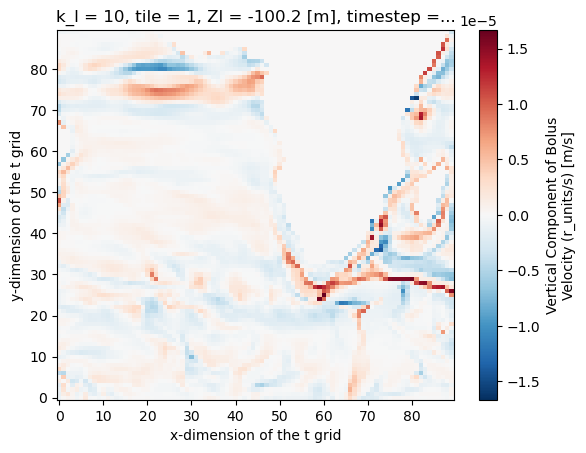

In [113]:
ecco_wvel_ex.WVELSTAR.isel(time=0,tile=1,k_l=10).plot()

## ECCO routines 

### routines to convert between SASSIE N1 faces and compact

In [3]:
def load_sassie_N1_field(file_dir, fname, nk=1, skip=0):
    num_cols = 680*4 + 1080
    num_rows = 1080
    
    time_level = int(fname.split('.data')[0].split('.')[-1])
    
    tmp_compact = ecco.load_binary_array(file_dir, fname, \
                                    num_rows, num_cols, nk=nk, skip=skip, filetype='>f4')

    return tmp_compact, time_level

In [5]:
def sassie_n1_compact_to_faces_2D(sassie_n1_compact):
    sassie_faces = dict()
    n = 680
    
    # Face 1 
    start_row = 0
    end_row = n
    sassie_faces[1] = sassie_n1_compact[start_row:end_row,:]

    # Face 2
    start_row = end_row
    end_row = start_row + n

    sassie_faces[2] = sassie_n1_compact[start_row:end_row,:]
    
    # Face 3
    start_row = end_row
    end_row = start_row + 1080
    sassie_faces[3] = sassie_n1_compact[start_row:end_row:,:]
    
    #Face 4
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[4] = sassie_n1_compact[start_row:end_row].reshape(1080, n)

    #Face 5
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[5] = sassie_n1_compact[start_row:end_row].reshape(1080, n)

    return sassie_faces

In [7]:
def sassie_n1_compact_to_faces_3D(sassie_n1_compact):
    sassie_faces = dict()
    n = 680
    
    # Face 1 
    start_row = 0
    end_row = n
    sassie_faces[1] = sassie_n1_compact[:,start_row:end_row,:]

    # Face 2
    start_row = end_row
    end_row = start_row + n
    sassie_faces[2] = sassie_n1_compact[:,start_row:end_row,:]
    
    # Face 3
    start_row = end_row
    end_row = start_row + 1080
    sassie_faces[3] = sassie_n1_compact[:,start_row:end_row:,:]
    
    #Face 4
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[4] = sassie_n1_compact[:,start_row:end_row].reshape(90, 1080, n)

    #Face 5
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[5] = sassie_n1_compact[:,start_row:end_row].reshape(90, 1080, n)

    return sassie_faces

In [9]:
def combine_sassie_N1_faces_to_HHv2_2D(face_arr):
    """
    2D function for scalar fields, c point
    """
    # dimensions of the final Arctic HH field. 535+185+1080=1800
    new_arr = np.zeros((1080, 1800)) 
    
    # cut out sections we want and assign them to location on HH
    new_arr[:, 185:185 + 1080] = face_arr[3]
    
    # rotate Face 1 to line up with orientation of Face 3
    new_arr[:, 0:185] = np.flipud(face_arr[1][-185:,:].T) # flip and transpose
    
    new_arr[:, 185 + 1080:] = face_arr[4][:,:535]

    new_arr = np.rot90(new_arr,2) # rotate it 180 so Greenland/AK are on bottom
    return new_arr

In [11]:
def combine_sassie_N1_faces_to_HHv2_2D_u_point(face_arr_u, face_arr_v):
    """
    2D function for vector fields, u point
    """
    ## dimensions of the final Arctic HH field. 535+185+1080=1800
    new_arr = np.zeros((1080, 1800))
    
    ## add Arctic face (3)
    new_arr[:, 185:185+1080] = face_arr_u[3] # take entire Artic face
    
    ## add face 1 that will be flipped (must use v array)
    new_arr[:, 0:185] = np.flipud(face_arr_v[1][-185:,:].T)
        
    ## add part of face 4 (Alaska)
    new_arr[:, 185+1080:] = face_arr_u[4][:,:535]

    ## rotate by 90 deg twice to have Alaska on bottom left
    ## since it is vector field, have to multiply whole array by -1
    new_arr = np.rot90(new_arr,2)
    new_arr = new_arr *-1
        
    return new_arr

In [13]:
def combine_sassie_N1_faces_to_HHv2_2D_v_point(face_arr_v, face_arr_u, vec=False):
    """
    2D function for vector fields, v point
    """
    ## dimensions of the final Arctic HH field. 535+185+1080=1800
    new_arr = np.zeros((1080, 1800))
    
    ## add Arctic face (3)
    new_arr[:, 185:185+1080] = face_arr_v[3]
    
    ## add part of face 1 (Europe) that will be flipped (must use u array and multiply by -1)
    
    ## after rotating face 1, the u points on face 1 will not match the v points of face 3 (offset by 1 upwards)
    ## therefore, must remove the first column of face 1 and add the first column from face 2 to the end of face 1
    ## remove the first i column from the u field so the shape is (680, 1079) = (j,i)
    face1_tmp = face_arr_u[1][:,1:]
    ## then add the first row from face 2 to the end of face 1
    face1_mod = np.concatenate((face1_tmp, face_arr_u[2][:,:1]), axis=1)
    
    ## add modified face 1 by rotating and multiplying by -1
    new_arr[:, 0:185] = np.flipud(face1_mod[-185:,:].T)*-1
    
    ## add part of face 4 (Alaska)
    new_arr[:, 185+1080:] = face_arr_v[4][:,:535]

    ## rotate by 90 deg twice to have Alaska on bottom left
    new_arr = np.rot90(new_arr,2)
    new_arr = new_arr *-1
        
    return new_arr

In [15]:
def combine_sassie_N1_faces_to_HHv2_3D(face_arr):
    """
    3D function for scalar fields, c point
    """
    # dimensions of the final Arctic HH field. 535+185+1080=1800 ; 90 vertical levels
    new_arr = np.zeros((90, 1080, 1800)) 
    
    # cut out sections we want and assign them to location on HH
    new_arr[:,:,185:185+1080] = face_arr[3]
    
    # rotate Face 1 to line up with orientation of Face 3
    new_arr[:,:,0:185] = np.transpose(face_arr[1][:,-185:,::-1],axes=(0,2,1)) # flip and transpose
    
    ## add part of face 4 (Alaska)
    new_arr[:,:,185+1080:] = face_arr[4][:,:,:535]
    
    ## rotate it 180 so Greenland/AK are on bottom
    new_arr = np.rot90(new_arr,2,axes=(1,2)) 
    
    return new_arr

In [17]:
def combine_sassie_N1_faces_to_HHv2_3D_u_point(face_arr_u, face_arr_v):
    """
    3D function for vector fields, u point
    """
    ## dimensions of the final Arctic HH field. 535+185+1080=1800 ; 90 vertical levels
    new_arr = np.zeros((90, 1080, 1800))
    
    ## add Arctic face (3)
    new_arr[:,:,185:185+1080] = face_arr_u[3] # take entire Artic face
    
    ## add face 1 that will be flipped (must use v array)
    new_arr[:,:,0:185] = np.transpose(face_arr_v[1][:,-185:,::-1],axes=(0,2,1))
        
    ## add part of face 4 (Alaska)
    new_arr[:,:,185+1080:] = face_arr_u[4][:,:,:535]

    ## rotate by 90 deg twice to have Alaska on bottom left
    ## since it is vector field, have to multiply whole array by -1
    new_arr = np.rot90(new_arr,2,axes=(1,2))
    new_arr = new_arr *-1
        
    return new_arr

In [19]:
def combine_sassie_N1_faces_to_HHv2_3D_v_point(face_arr_v, face_arr_u):
    """
    3D function for vector fields, v point
    """
    ## dimensions of the final Arctic HH field. 535+185+1080=1800
    new_arr = np.zeros((90, 1080, 1800))
    
    ## add Arctic face (3)
    new_arr[:,:,185:185+1080] = face_arr_v[3]
    
    ## add part of face 1 (Europe) that will be flipped (must use u array and multiply by -1)
    
    ## after rotating face 1, the u points on face 1 will not match the v points of face 3 (offset by 1 upwards)
    ## therefore, must remove the first column of face 1 and add the first column from face 2 to the end of face 1
    ## remove the first i column from the u field so the shape is (680, 1079) = (j,i)
    face1_tmp = face_arr_u[1][:,:,1:]
    ## then add the first row from face 2 to the end of face 1
    face1_mod = np.concatenate((face1_tmp, face_arr_u[2][:,:,:1]), axis=2)
    
    ## add modified face 1 by rotating and multiplying by -1
    new_arr[:,:,0:185] = np.transpose(face1_mod[:,-185:,::-1],axes=(0,2,1))*-1
    
    ## add part of face 4 (Alaska)
    new_arr[:,:,185+1080:] = face_arr_v[4][:,:,:535]

    ## rotate by 90 deg twice to have Alaska on bottom left
    new_arr = np.rot90(new_arr,2,axes=(1,2))
    new_arr = new_arr *-1
        
    return new_arr

In [21]:
def timestamp_from_iter_num(iter_num):
    """
    takes the model iteration that was pulled from the data's filename and converts it to its equivalent datetime
    """
    ## Start time of the model is 5790000 (22.0319 years after 1992-01-01)
    ## there are 120 seconds for each iteration and 86400 seconds per day
    ## take the iteration number, convert to seconds, and calculate number of days since start of model
    
    num_days_since_start = iter_num*120 / 86400 ## divide iter_number by 86400 which is equal to the number of seconds in a day
    model_start_time = datetime(1992,1,1) # data.cal start time is 1992-01-01
    
    timestamp = np.array([model_start_time + timedelta(days=num_days_since_start)], dtype='datetime64[ns]')
    
    return timestamp

In [23]:
def unpack_tar_gz_files(data_dir):
    ## see if tar.gz files were already decompressed
    data_files = list(data_dir.glob('*.data'))
    if len(data_files)>0:
        print("tar.gz files already unpacked")
    ## if not, open them
    else:
        ## pull list of all tar.gz files in directory
        tar_gz_files = list(data_dir.glob('*.tar.gz'))
        
        ## unzip targz file
        for file_path in tar_gz_files:
            tar = tarfile.open(file_path, "r:gz")
            tar.extractall(data_dir) # save files to same directory
            tar.close()

In [25]:
def make_2D_HHv2_ds(field_HH, model_grid_ds, timestamp, grid_point, da_name):
    
    ## get time bounds and center time
    time_bnds, center_time = ecco.make_time_bounds_from_ds64(timestamp[0], 'AVG_DAY')
    time_bnds_da = xr.DataArray(time_bnds.reshape(1,2), dims=['time', 'nv'])
    
    ## create DataArray for c point data
    if grid_point == 'c':
        tmp_da = xr.DataArray([field_HH], dims=['time','j','i'],\
                                coords={'time':(('time'), np.array([center_time]))})
    
    ## create DataArray for u point data
    elif grid_point == 'u':
        tmp_da = xr.DataArray([field_HH], dims=['time','j','i_g'],\
                                coords={'time':(('time'), np.array([center_time]))})
    
    ## create DataArray for v point data
    elif grid_point == 'v':
        tmp_da = xr.DataArray([field_HH], dims=['time','j_g','i'],\
                                coords={'time':(('time'), np.array([center_time]))})
    
    ## name the array
    tmp_da.name = da_name
    
    ## add additional coordinates to dataset
    tmp_ds = tmp_da.to_dataset().assign_coords({
        'time_bnds':time_bnds_da,\
        'XC':model_grid_ds.XC,\
        'YC':model_grid_ds.YC,\
        'XG':model_grid_ds.XG,\
        'YG':model_grid_ds.YG,\
        'XC_bnds':model_grid_ds.XC_bnds,\
        'YC_bnds':model_grid_ds.YC_bnds,\
        'Zp1':model_grid_ds.Zp1})
    
    return tmp_ds

In [27]:
def make_3D_HHv2_ds(field_HH, model_grid_ds, timestamp, grid_point, da_name, k_face='center'):
    
    ## get time bounds and center time
    time_bnds, center_time = ecco.make_time_bounds_from_ds64(timestamp[0], 'AVG_DAY')
    time_bnds_da = xr.DataArray(time_bnds.reshape(1,2), dims=['time', 'nv'])
    
    if k_face == 'center':
        
        ## create DataArray for c point data, center
        if grid_point == 'c':
            tmp_da = xr.DataArray([field_HH], dims=['time', 'k','j','i'],\
                                    coords={'time':(('time'),np.array([center_time]))})
            tmp_da['k'].attrs['axis']  = 'Z'
            
        ## create DataArray for u point data, center
        elif grid_point == 'u':
            tmp_da = xr.DataArray([field_HH], dims=['time', 'k','j','i_g'],\
                                    coords={'time':(('time'),np.array([center_time]))})
            tmp_da['k'].attrs['axis']  = 'Z'
            
        ## create DataArray for v point data, center
        elif grid_point == 'v':
            tmp_da = xr.DataArray([field_HH], dims=['time', 'k','j_g','i'],\
                                    coords={'time':(('time'),np.array([center_time]))})
            tmp_da['k'].attrs['axis']  = 'Z'            
            
    elif k_face == 'top':
        ## create DataArray for c point data, top
        tmp_da = xr.DataArray([field_HH], dims=['time','k_l','j','i'],\
                                coords={'time':(('time'),np.array([center_time]))})
        tmp_da['k_l'].attrs['axis']  = 'Z'

    ## name the array
    tmp_da.name = da_name
        
    ## add additional coordinates to dataset
    tmp_ds = tmp_da.to_dataset().assign_coords({
        'time_bnds':time_bnds_da,\
        'XC':model_grid_ds.XC,\
        'YC':model_grid_ds.YC,\
        'XG':model_grid_ds.XG,\
        'YG':model_grid_ds.YG,\
        'XC_bnds':model_grid_ds.XC_bnds,\
        'YC_bnds':model_grid_ds.YC_bnds,\
        'Z':model_grid_ds.Z,\
        'Zu':model_grid_ds.Zu,\
        'Zl':model_grid_ds.Zl,\
        'Zp1':model_grid_ds.Zp1})
        
 #   tmp_da = add_geo_metadata(tmp_da)

    return tmp_ds

In [29]:
def process_2D_variable(data_dir, filename, var_tmp_table, vars_table, sassie_n1_geometry_ds):
    
    var_name = var_tmp_table['variable'].values[0]
    n_skip = var_tmp_table['field_index'].values[0] * 1
    grid_point = var_tmp_table.cgrid_point.values
    
    ## process binary data to compact format
    data_compact, iter_num = load_sassie_N1_field(str(data_dir), filename, nk=1, skip=n_skip)
    
    ## convert compact format to 5 faces
    data_faces = sassie_n1_compact_to_faces_2D(data_compact)
    
    ## convert faces to HHv2 Arctic rectangle
    ## data on u and v points need to be handled differently from c points
    if var_tmp_table.data_type.values == 'V': # if it is a vector field
        var_mate = var_tmp_table.mate.values[0]
        var_table_mate = vars_table[vars_table.variable.values == var_mate]
        var_mate_field_index = var_table_mate.field_index.values[0]
        
        if grid_point == 'v':
            ## get u field
            n_skip_u = var_mate_field_index
            data_compact_u, iter_num = load_sassie_N1_field(str(data_dir), filename, nk=1, skip=n_skip_u)
            face_arr_u = sassie_n1_compact_to_faces_2D(data_compact_u)
            
            ## process v field
            var_HHv2 = combine_sassie_N1_faces_to_HHv2_2D_v_point(data_faces, face_arr_u)
            
        elif grid_point == 'u':
            ## get v field
            n_skip_v = var_mate_field_index
            data_compact_v, iter_num = load_sassie_N1_field(str(data_dir), filename, nk=1, skip=n_skip_v)
            face_arr_v = sassie_n1_compact_to_faces_2D(data_compact_v)
            
            ## process u field
            var_HHv2 = combine_sassie_N1_faces_to_HHv2_2D_u_point(data_faces, face_arr_v)
            
    elif var_tmp_table.data_type.values == 'S': # if it is a scalar field
        var_HHv2 = combine_sassie_N1_faces_to_HHv2_2D(data_faces)
    
    ## add timestamp adn create dataset
    timestamp = timestamp_from_iter_num(iter_num)
    var_HHv2_ds = make_2D_HHv2_ds(var_HHv2, sassie_n1_geometry_ds, timestamp, grid_point=grid_point, da_name=var_name)
    
    return var_HHv2_ds

In [31]:
def process_3D_variable(data_dir, filename, var_tmp_table, vars_table, sassie_n1_geometry_ds):
    
    var_name = var_tmp_table['variable'].values[0]
    
    ## there are 90 vertical levels; use index from table to identify how many fields to skip
    n_skip = var_tmp_table['field_index'].values[0] * 90
    var_k_face = var_tmp_table['k_face'].values[0]
    grid_point = var_tmp_table.cgrid_point.values
    
    ## process binary data to compact format
    data_compact, iter_num = load_sassie_N1_field(str(data_dir), filename, nk=90, skip=n_skip)
    
    ## convert compact format to 5 faces
    data_faces = sassie_n1_compact_to_faces_3D(data_compact)
    
    ## convert faces to HHv2 Arctic rectangle
    ## data on u and v points need to be handled differently from c points
    if var_tmp_table.data_type.values == 'V': # if it is a vector field
        var_mate = var_tmp_table.mate.values[0]
        var_table_mate = vars_table[vars_table.variable.values == var_mate]
        var_mate_field_index = var_table_mate.field_index.values[0]
        
        if grid_point == 'v':
            ## get u field
            n_skip_u = var_mate_field_index * 90
            data_compact_u, iter_num = load_sassie_N1_field(str(data_dir), filename, nk=90, skip=n_skip_u)
            face_arr_u = sassie_n1_compact_to_faces_3D(data_compact_u)
            
            ## process v field
            var_HHv2 = combine_sassie_N1_faces_to_HHv2_3D_v_point(data_faces, face_arr_u)
            
        elif grid_point == 'u':
            ## get v field
            n_skip_v = var_mate_field_index * 90
            data_compact_v, iter_num = load_sassie_N1_field(str(data_dir), filename, nk=90, skip=n_skip_v)
            face_arr_v = sassie_n1_compact_to_faces_3D(data_compact_v)
            
            ## process u field
            var_HHv2 = combine_sassie_N1_faces_to_HHv2_3D_u_point(data_faces, face_arr_v)
        
    elif var_tmp_table.data_type.values == 'S': # if it is a scalar field
        var_HHv2 = combine_sassie_N1_faces_to_HHv2_3D(data_faces) # c point
    
    ## add timestamp and create dataset
    timestamp = timestamp_from_iter_num(iter_num)
    var_HHv2_ds = make_3D_HHv2_ds(var_HHv2, sassie_n1_geometry_ds, timestamp, grid_point=grid_point, da_name=var_name, k_face=var_k_face)
    
    return var_HHv2_ds

In [69]:
def mask_dry_grid_cells(ds, var, geometry_ds, grid_point):
    ## make copy of dataset
    ds_tmp = ds.copy(deep=True)
    
    ## tracer points use maskC, u points use maskW, and v points use maskS
    if grid_point == 'c':
        ds_tmp[var] = ds[var].where(geometry_ds.maskC==True)
        
    elif grid_point == 'v':
        ds_tmp[var] = ds[var].where(geometry_ds.maskS==True)
        
    elif grid_point == 'u':
        ds_tmp[var] = ds[var].where(geometry_ds.maskW==True)
    
    return ds_tmp

In [35]:
def create_encoding(ecco_ds, output_array_precision = np.float32):
    
    # Create NetCDF encoding directives
    # ---------------------------------------------
    # print('\n... creating variable encodings')
    # ... data variable encoding directives
    
    # Define fill values for NaN
    if output_array_precision == np.float32:
        netcdf_fill_value = nc4.default_fillvals['f4']

    elif output_array_precision == np.float64:
        netcdf_fill_value = nc4.default_fillvals['f8']
    
    dv_encoding = dict()
    for dv in ecco_ds.data_vars:
        dv_encoding[dv] =  {'zlib':True, \
                            'complevel':5,\
                            'shuffle':True,\
                            '_FillValue':netcdf_fill_value}

    # ... coordinate encoding directives
    # print('\n... creating coordinate encodings')
    coord_encoding = dict()
    for coord in ecco_ds.coords:
        # set default no fill value for coordinate
        if output_array_precision == np.float32:
            coord_encoding[coord] = {'_FillValue':None, 'dtype':'float32'}
        elif output_array_precision == np.float64:
            coord_encoding[coord] = {'_FillValue':None, 'dtype':'float64'}

        # force 64 bit ints to be 32 bit ints
        if (ecco_ds[coord].values.dtype == np.int32) or \
           (ecco_ds[coord].values.dtype == np.int64) :
            coord_encoding[coord]['dtype'] ='int32'

        # fix encoding of time
        if coord == 'time' or coord == 'time_bnds':
            coord_encoding[coord]['dtype'] ='int32'

            if 'units' in ecco_ds[coord].attrs:
                # apply units as encoding for time
                coord_encoding[coord]['units'] = ecco_ds[coord].attrs['units']
                # delete from the attributes list
                del ecco_ds[coord].attrs['units']

        elif coord == 'time_step':
            coord_encoding[coord]['dtype'] ='int32'

    # ... combined data variable and coordinate encoding directives
    encoding = {**dv_encoding, **coord_encoding}

    return encoding

In [37]:
def modify_metadata(ds, var, var_filename_netcdf):   
    title = 'SASSIE Ocean Model ' + var + ' Parameter for the Lat-Lon-Cap 1080 (llc1080) Native Model Grid (Version 1 Release 1)'
    
    ## edit specific metadata for these datasets
    ds.attrs['author'] = 'Mike Wood, Marie Zahn, and Ian Fenty'
    ds.attrs['comment'] = 'SASSIE llc1080 V1R1 fields are consolidated onto a single curvilinear grid face focusing on the Arctic domain using fields from the 5 faces of the lat-lon-cap 1080 (llc1080) native grid used in the original simulation.'
    ds.attrs['id'] = '10.5067/XXXXX-XXXXX' # will update with DOI when avail
    ds.attrs['geospatial_vertical_min'] = np.round(ds.Zu.min().values,1)
    ds.attrs['geospatial_lat_min'] = np.round(ds.YC.min().values,1)
    ds.attrs['metadata_link'] = 'https://cmr.earthdata.nasa.gov/search/collections.umm_json?ShortName=XXXX_L4_GEOMETRY_LLC1080GRID_V1R1' # will update with DOI when avail
    ds.attrs['product_name'] = var_filename_netcdf
    ds.attrs['time_coverage_end'] = str(ds.time_bnds.values[0][0])[:-10]
    ds.attrs['time_coverage_start'] = str(ds.time_bnds.values[0][1])[:-10]
    ds.attrs['product_version'] = 'Version 1, Release 1'
    ds.attrs['program'] = 'NASA Physical Oceanography'
    ds.attrs['source'] = 'The SASSIE ocean model simulation was produced by downscaling the global ECCO state estimate from 1/3 to 1/12 degree grid cells. The ECCO global solution provided initial and boundary conditions and atmospheric forcing.'
    ds.attrs['references'] = 'TBD'
    ds.attrs['summary'] = 'This dataset provides data variable and geometric parameters for the lat-lon-cap 1080 (llc1080) native model grid from the SASSIE ECCO ocean model Version 1 Release 1 (V1r1) ocean and sea-ice state estimate.'
    ds.attrs['title'] = title
    ds.attrs['uuid'] = str(uuid.uuid1())
    
    ## remove some attributes we don't need
    attributes_to_remove = ['product_time_coverage_start', 'product_time_coverage_end',\
                            'geospatial_lat_resolution', 'geospatial_lon_resolution']
    
    ## add current time and date
    current_time = datetime.now().isoformat()[0:19]
    ds.attrs['date_created'] = current_time
    ds.attrs['date_modified'] = current_time
    ds.attrs['date_metadata_modified'] = current_time
    ds.attrs['date_issued'] = current_time
    
    for attr in attributes_to_remove:
        ds.attrs.pop(attr, None)
        
    return ds

In [39]:
def reorder_dims(xr_dataset):
    ## specify order of dims
    tmp = xr_dataset[["time","j","i","k","j_g","i_g","k_u","k_l","k_p1","nv","nb"]]
    tmp = tmp.drop_indexes(["nv","nb"]).reset_coords(["nv","nb"], drop=True)
    
    ## reassign dataset to new dims
    xr_ds_ordered = tmp.assign(xr_dataset)
    
    return xr_ds_ordered

In [41]:
def save_sassie_netcdf(var_HHv2_ds, output_dir, root_filename, var_filename_netcdf, var_name):
    ## save netCDF files
    ## create output directory if it doesn't already exist
    output_dir_path = Path(output_dir + root_filename + "/" + var_name)
    output_dir_path.mkdir(parents=True, exist_ok=True) 
    
    encoding_var = create_encoding(var_HHv2_ds, output_array_precision = np.float32)
    
    var_HHv2_ds.to_netcdf(output_dir_path / var_filename_netcdf, encoding = encoding_var)
    var_HHv2_ds.close()
    
    print('\n==== saved netcdf: ' + var_filename_netcdf + ' ====\n')

In [43]:
def plot_sassie_HHv2_3D(face_arr, depth_level=0, vmin=None, vmax=None,\
    cmap='jet', axs = None, \
    show_colorbar=True):

    tmp = combine_sassie_N1_faces_to_HHv2_3D(face_arr)

    if vmin == None:
        vmin = np.min(tmp)
    if vmax == None:
        vmax = np.max(tmp)

    if axs == None:
        plt.imshow(tmp[depth_level,:,:], origin='lower', interpolation='none',vmin=vmin,vmax=vmax, cmap=cmap)
        if show_colorbar:
            plt.colorbar()

    else:
        im1 = axs.imshow(tmp[depth_level,:,:], origin='lower', interpolation='none',vmin=vmin,vmax=vmax, cmap=cmap)
        fig = plt.gcf()
        if show_colorbar:
            fig.colorbar(im1, ax=axs)

# Create routine to process files

In [174]:
## model geometry
sassie_n1_geometry_ds = xr.open_dataset('/Users/mzahn/data/SASSIE/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc')

In [ ]:
sassie_n1_geometry_ds

In [47]:
## open table that provides info for proper indexing based on desired variable
vars_table = pd.read_csv('sassie_variables_table.csv', index_col=False)

In [49]:
## where to save netCDFs with directories for each variable
output_dir = '/Users/mzahn/data/SASSIE/SASSIE_netcdfs/'

In [51]:
## metadata directory
metadata_json_dir = '/Users/mzahn/github_others/ECCO-GROUP/ECCO-ACCESS/metadata/ECCOv4r4_metadata_json'

In [53]:
## model data directory
sassie_llc1080_data_dir = '/Users/mzahn/data/SASSIE/SASSIE_examples/'

In [45]:
## model data directory
sassie_llc1080_data_dir = '/Users/mzahn/data/SASSIE/SASSIE_examples/'

## output (CHANGE TO S3 BUCKET)
output_dir = '/Users/mzahn/data/SASSIE/SASSIE_netcdfs/'


## geometry
sassie_geometry_dir = '/Users/mzahn/data/SASSIE/'

## variable table directory
variable_table_dir = '/Users/mzahn/github/SASSIE_downscale_ecco_v5/'

## metadata directory
metadata_json_dir = '/Users/mzahn/github_others/ECCO-GROUP/ECCO-ACCESS/metadata/ECCOv4r4_metadata_json/'

## selected variables to process
vars_select = ['THETA', 'SALT']
# vars_select = ['SIarea', 'SIuice']
# vars_select = ['UVEL','VVEL']
# vars_select = ['UVEL']

In [71]:
def generate_sassie_ecco_netcdfs(sassie_llc1080_data_dir, sassie_geometry_dir,\
                                 variable_table_dir, output_dir, vars_select):
    
    """
    vars_select = list of selected variables to process
    vars_table = full table of data variables and diagnostic info
    var_tmp_table = single row table for `var` variable in loop
    
    all datasets from `root_filenames` will be downloaded based on requested variables
    """
    
    ## open model geometry
    sassie_n1_geometry_ds = xr.open_dataset(sassie_geometry_dir + 'GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc')
    
    ## open table that provides info for proper indexing based on desired variable
    vars_table = pd.read_csv(variable_table_dir + 'sassie_variables_table.csv', index_col=False)
    
    ## load metadata --------------------------------------------
    metadata_fields = ['ECCOv4r4_global_metadata_for_all_datasets',
                       'ECCOv4r4_global_metadata_for_latlon_datasets',
                       'ECCOv4r4_global_metadata_for_native_datasets',
                       'ECCOv4r4_coordinate_metadata_for_1D_datasets',
                       'ECCOv4r4_coordinate_metadata_for_latlon_datasets',
                       'ECCOv4r4_coordinate_metadata_for_native_datasets',
                       'ECCOv4r4_geometry_metadata_for_latlon_datasets',
                       'ECCOv4r4_geometry_metadata_for_native_datasets',
                       'ECCOv4r4_groupings_for_1D_datasets',
                       'ECCOv4r4_groupings_for_latlon_datasets',
                       'ECCOv4r4_groupings_for_native_datasets',
                       'ECCOv4r4_variable_metadata',
                       'ECCOv4r4_variable_metadata_for_latlon_datasets',
                       'ECCOv4r4_dataset_summary']
    
    ## load metadata
    metadata = dict()
    
    for mf in metadata_fields:
        mf_e = mf + '.json'
        # print(mf_e)
        with open(Path(metadata_json_dir + mf_e), 'r') as fp:
            metadata[mf] = json.load(fp)
            
    global_latlon_metadata = metadata['ECCOv4r4_global_metadata_for_all_datasets'] + metadata['ECCOv4r4_global_metadata_for_latlon_datasets']
    
    ## identify root_filenames for selected data variables
    table_select = vars_table[vars_table.variable.isin(vars_select)]
    root_filenames = np.unique(table_select['root_filename'].values)
    
    ## loop through each variable that was requested (`vars_select`) --------------------------------------------
    for var in vars_select:
        print('#### ==== processing:', var, '==== #### \n')
        
        ## get root directory for variable and then define directory
        var_tmp_table = vars_table[vars_table.variable.isin([var])]
        root_filename = var_tmp_table.root_filename.values[0]
        data_dir = Path(sassie_llc1080_data_dir + root_filename)
    
        ## unpack tar_gz files
        ## only decompresses tar.gz file if *data files are not present in the directory
        unpack_tar_gz_files(data_dir)
        
        ## loop through files in root directory
        data_files = np.sort(list(data_dir.glob('*.data')))
        
        for file in data_files:
            print('loading file: ', file)
            
            ## get filename
            filename = str(file).split('/')[-1]
            
            ## 3D data processing
            if var_tmp_table['n_dims'].values == '3D':
                ## process dataset
                var_HHv2_ds = process_3D_variable(data_dir, filename, var_tmp_table,\
                                                  vars_table, sassie_n1_geometry_ds)
            ## 2D data processing 
            elif var_tmp_table['n_dims'].values == '2D':
                ## process dataset
                var_HHv2_ds = process_2D_variable(data_dir, filename, var_tmp_table,\
                                                  vars_table, sassie_n1_geometry_ds)
            
            ## mask land cells
            var_HHv2_ds = mask_dry_grid_cells(var_HHv2_ds, var, sassie_n1_geometry_ds, grid_point=var_tmp_table['cgrid_point'].values)
            
            ## add metadata
            var_HHv2_ds = ecco.add_global_metadata(global_latlon_metadata, var_HHv2_ds, var_tmp_table['n_dims'].values[0])
            var_HHv2_ds = ecco.add_coordinate_metadata(metadata['ECCOv4r4_coordinate_metadata_for_latlon_datasets'], var_HHv2_ds, less_output=True)
            var_HHv2_ds, grouping_keywords = ecco.add_variable_metadata(metadata['ECCOv4r4_geometry_metadata_for_latlon_datasets'], var_HHv2_ds, less_output=True)
            var_HHv2_ds, grouping_keywords = ecco.add_variable_metadata(metadata['ECCOv4r4_variable_metadata'], var_HHv2_ds, less_output=True)
            
            ## generate filename
            center_time = var_HHv2_ds.time.values
            yyyy_mm_dd = str(center_time)[2:6] + "-" + str(center_time)[7:9] + "-" + str(center_time)[10:12]
            var_filename_netcdf = var + "_day_mean_" + yyyy_mm_dd + "_ECCO_SASSIE_V1_HH_llc1080.nc"
            
            ## tweak some of the global attributes
            var_HHv2_ds = modify_metadata(var_HHv2_ds, var, var_filename_netcdf)
            
            ## reorder dims
            var_HHv2_ds_ordered = reorder_dims(var_HHv2_ds)
            
            ## save netcdf
            save_sassie_netcdf(var_HHv2_ds_ordered, output_dir, root_filename, var_filename_netcdf, var)
            
    # return(var_HHv2_ds_final)
    print("######## processing complete ########")

In [73]:
generate_sassie_ecco_netcdfs(sassie_llc1080_data_dir, sassie_geometry_dir,\
                             variable_table_dir, output_dir, vars_select=['THETA','SALT','UVEL','VVEL'])

#### ==== processing: THETA ==== #### 

tar.gz files already unpacked
loading file:  /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_3D_day_mean/ocean_state_3D_day_mean.0005796720.data
load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_3D_day_mean/ocean_state_3D_day_mean.0005796720.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4

==== saved netcdf: THETA_day_mean_2014-01-15_ECCO_SASSIE_V1_HH_llc1080.nc ====

loading file:  /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_3D_day_mean/ocean_state_3D_day_mean.0005797440.data
load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_3D_day_mean/ocean_state_3D_day_mean.0005797440.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4

==== saved netcdf: THETA_day_mean_2014-01-16_ECCO_SASSIE_V1_HH_llc1080.nc ====

#### ==== processing: SALT ==== #### 

tar.gz files already unpack

In [153]:
## look at example files

## velocity
uvel_tmp = xr.open_dataset('/Users/mzahn/data/SASSIE/SASSIE_netcdfs/ocean_vel_day_mean/UVEL/UVEL_day_mean_2014-01-16_ECCO_SASSIE_V1_HH_llc1080.nc')
uvel_tmp.close()

## velocity
vvel_tmp = xr.open_dataset('/Users/mzahn/data/SASSIE/SASSIE_netcdfs/ocean_vel_day_mean/VVEL/VVEL_day_mean_2014-01-16_ECCO_SASSIE_V1_HH_llc1080.nc')
vvel_tmp.close()

## salt
salt_tmp = xr.open_dataset('/Users/mzahn/data/SASSIE/SASSIE_netcdfs/ocean_state_3D_day_mean/SALT/SALT_day_mean_2014-01-16_ECCO_SASSIE_V1_HH_llc1080.nc')
salt_tmp.close()

## theta
temp_tmp = xr.open_dataset('/Users/mzahn/data/SASSIE/SASSIE_netcdfs/ocean_state_3D_day_mean/THETA/THETA_day_mean_2014-01-15_ECCO_SASSIE_V1_HH_llc1080.nc')
temp_tmp.close()

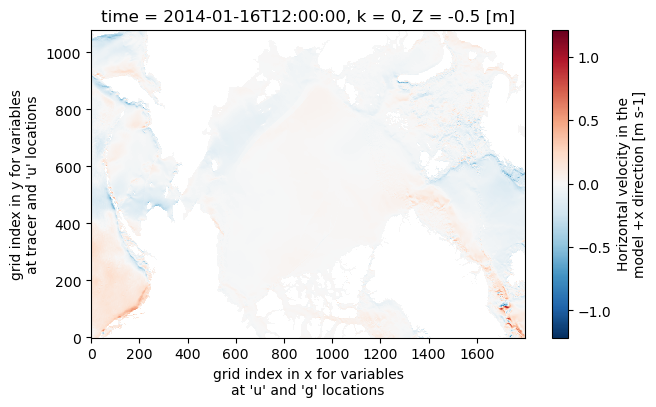

In [108]:
uvel_tmp.UVEL.isel(time=0,k=0).plot(figsize=(7,4));

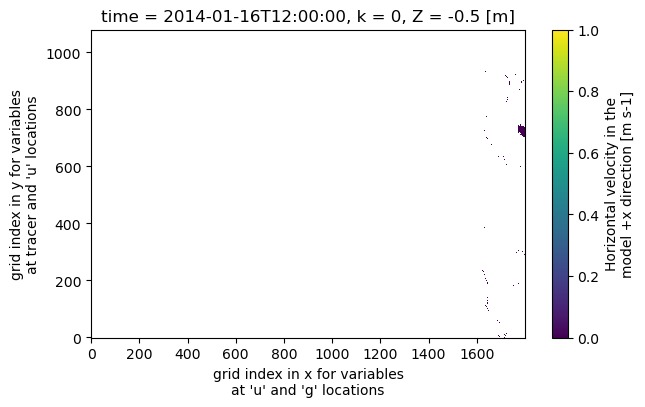

In [165]:
uvel_tmp.where(uvel_tmp == 0).UVEL.isel(time=0,k=0).plot(figsize=(7,4), vmin=0, vmax=1)

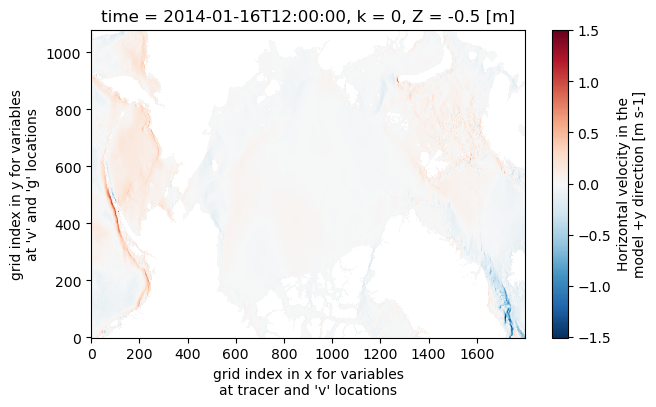

In [155]:
vvel_tmp.VVEL.isel(time=0,k=0).plot(figsize=(7,4));

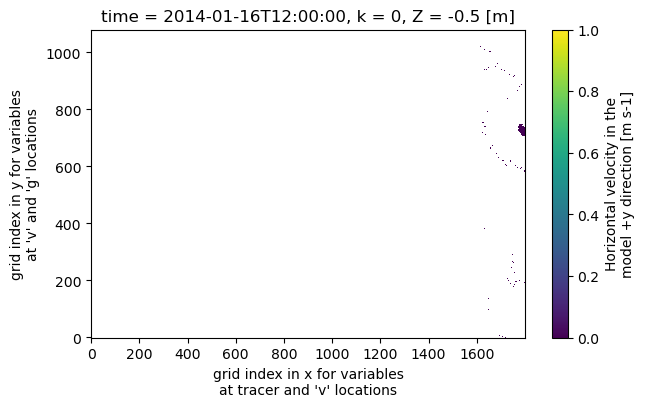

In [169]:
vvel_tmp.where(vvel_tmp == 0).VVEL.isel(time=0,k=0).plot(figsize=(7,4), vmin=0, vmax=1)

**Daily data - HH**

SHORTNAME: ECCO_SASSIE_L4_VARNAME_LLC1080GRID_DAILY_V1 

**Hourly data - Beaufort**

SHORTNAME: ECCO_SASSIE_L4_VARNAME_LLC1080GRID_HOURLY_V1 

VARNAME_day_mean_1992-01-01_ECCO_SASSIE_V1_HH_llc1080

VARNAME_hour_mean_1992-01-01T00_ECCO_SASSIE_V1_BG_llc1080
VARNAME_hour_mean_1992-01-01T23_ECCO_SASSIE_V1_BG_llc1080

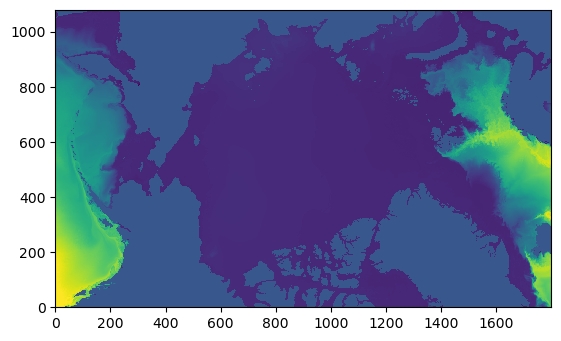

In [ ]:
plt.imshow(tmp.THETA.isel(k=0,time=0), origin='lower', interpolation='none',vmin=-3,vmax=8)

In [78]:
import cartopy.crs as ccrs

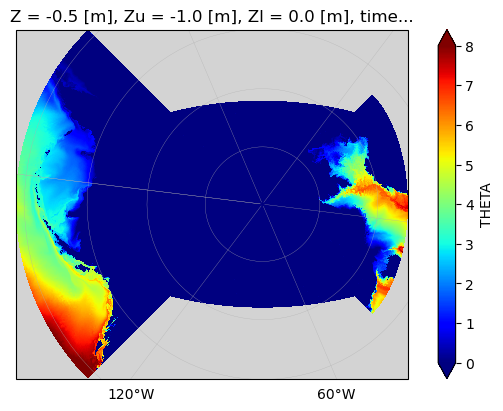

In [84]:
fig = plt.figure(figsize=(7,4), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -83))
# ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

tmp.THETA.isel(k=0,time=0).plot(x='XC',y='YC',ax=ax1,vmin=0,vmax=8,cmap='jet',transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
# ax1.set_title("depth=" + str(theta_350m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False

Open all datasets in theta and salt directories

In [60]:
## open all datasets in theta directory
theta_ds_dir = Path('/Users/mzahn/data/SASSIE/SASSIE_netcdfs/ocean_state_3D_day_mean/THETA/')
theta_ds_dir_list = list(theta_ds_dir.glob('*.nc'))

In [62]:
theta_ds = xr.open_mfdataset(theta_ds_dir_list, chunks='auto', parallel=True)

In [64]:
theta_ds

<xarray.Dataset>
Dimensions:  (j: 1080, i: 1800, k: 90, time: 19)
Coordinates:
    XC       (j, i) float32 dask.array<chunksize=(1080, 1800), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(1080, 1800), meta=np.ndarray>
    Z        (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    Zu       (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    Zl       (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2014-01-16 2014-01-17 ... 2014-02-03
Dimensions without coordinates: j, i, k
Data variables:
    THETA    (time, k, j, i) float64 dask.array<chunksize=(1, 23, 270, 450), meta=np.ndarray>

***